In [1]:
# Cell 1 — Imports & GPU setup (optional)

import os, glob, math, random
from pathlib import Path

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# If you have a GPU, this avoids allocating all VRAM at once
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except Exception as e:
        print("GPU memory growth setup failed:", e)

2025-09-20 18:47:28.526024: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-20 18:47:28.534710: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758372448.544999  329419 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758372448.548192  329419 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1758372448.555918  329419 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# Cell 2 — Configuration (REPLACED)

# Point this to your folder of phone photos for ONE object category
DATA_DIR = "Akif_Images"    # <-- change to your path

IMG_SIZE = 256                 # 64/96/128 recommended for phone photos
CHANNELS = 3
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, CHANNELS)

BATCH_SIZE = 64
EPOCHS = 1000                    # increase for better quality if you have time/GPU
LATENT_DIM = 64              # try 8..64; larger can yield richer samples
LEARNING_RATE = 2e-4
KL_WEIGHT = 1.0

# We will run BOTH losses in one go
RECON_LOSSES = ["bce", "mse"]  # order matters for consistent plotting/colors

# Output dirs
from pathlib import Path
OUT = Path("outputs")
FIG_DIR = OUT / "figures"
GEN_DIR = OUT / "generations"
MODEL_DIR = OUT / "models"
for d in [OUT, FIG_DIR, GEN_DIR, MODEL_DIR]:
    d.mkdir(parents=True, exist_ok=True)

def tag(loss_name):
    return f"{loss_name}_latent{LATENT_DIM}_img{IMG_SIZE}"

Found 100 images


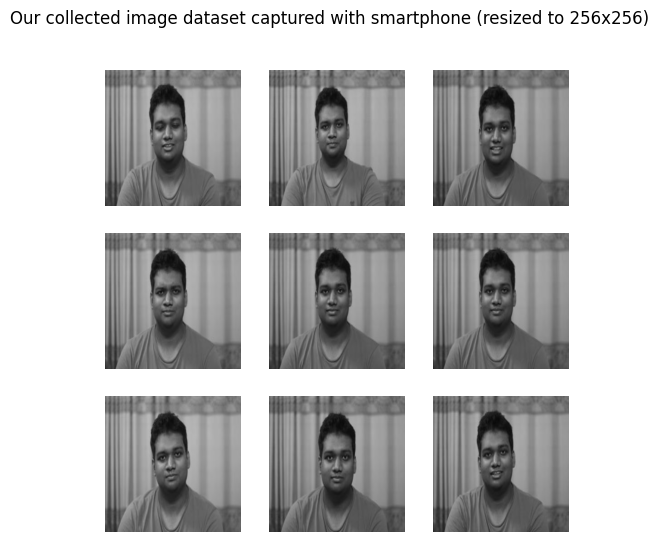

In [13]:
# Cell 3 — Data loader (tf.data) for a flat folder of images

def list_images(root):
    exts = ("*.jpg", "*.jpeg", "*.png", "*.bmp", "*.webp","*.JPG")
    files = []
    for e in exts:
        files.extend(glob.glob(os.path.join(root, e)))
    return files

files = list_images(DATA_DIR)
if len(files) == 0:
    raise FileNotFoundError(f"No images found in {DATA_DIR}. Put your phone photos there.")

print(f"Found {len(files)} images")

def load_and_preprocess(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_image(img, channels=CHANNELS, expand_animations=False)
    img = tf.image.convert_image_dtype(img, tf.float32)         # [0,1]
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE), antialias=True)
    return img

path_ds = tf.data.Dataset.from_tensor_slices(files)
ds = (path_ds
      .shuffle(len(files), seed=SEED)
      .map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
      .batch(BATCH_SIZE)
      .prefetch(tf.data.AUTOTUNE))

# Peek a few images
sample_batch = next(iter(ds))
plt.figure(figsize=(6,6))
for i in range(min(9, sample_batch.shape[0])):
    plt.subplot(3,3,i+1)
    plt.imshow(sample_batch[i].numpy())
    plt.axis("off")
plt.suptitle("Our collected image dataset captured with smartphone (resized to {}x{})".format(IMG_SIZE, IMG_SIZE))
plt.show()

In [4]:
# Cell 4 — Sampling layer (reparameterization trick)

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z = z_mean + exp(0.5 * z_log_var) * epsilon"""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [5]:
# Cell 5 — Build Encoder

def build_encoder(img_shape=IMG_SHAPE, latent_dim=LATENT_DIM):
    encoder_inputs = keras.Input(shape=img_shape)
    x = layers.Conv2D(32, 3, strides=2, padding="same", activation="relu")(encoder_inputs)
    x = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(128, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    return encoder

encoder = build_encoder()
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     18,496 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     73,856 │ conv2d_1[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 131072)    │          0 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │ 16,777,344 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 64)        │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,887,104 (64.42 MB)

 Trainable params: 16,887,104 (64.42 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Cell 6 — Build Decoder

def build_decoder(img_shape=IMG_SHAPE, latent_dim=LATENT_DIM):
    h, w, c = img_shape
    # Compute the spatial dims after 3 stride-2 downsamples (ceil for odd sizes)
    s = (int(math.ceil(h / 8)), int(math.ceil(w / 8)))  # after 3 strided convs
    units = s[0] * s[1] * 128

    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(units, activation="relu")(latent_inputs)
    x = layers.Reshape((s[0], s[1], 128))(x)
    x = layers.Conv2DTranspose(128, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
    # Final layer: sigmoid for [0,1] images
    decoder_outputs = layers.Conv2D(CHANNELS, 3, padding="same", activation="sigmoid")(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
    return decoder

decoder = build_decoder()
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 131072)         │     8,519,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 64, 64, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 128, 128, 64)   │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 256, 256, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 256, 256, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,760,387 (33.42 MB)

 Trainable params: 8,760,387 (33.42 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Cell 7 — VAE model (subclassed) with custom train_step (Keras example style)

class VAE(keras.Model):
    def __init__(self, encoder, decoder, recon_loss="bce", kl_weight=1.0, **kwargs):
        super().__init__(**kwargs)
        assert recon_loss in {"bce", "mse"}
        self.encoder = encoder
        self.decoder = decoder
        self.recon_loss = recon_loss
        self.kl_weight = kl_weight

        self.total_loss_tracker = keras.metrics.Mean(name="loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        if isinstance(data, tuple):
            x = data[0]
        else:
            x = data

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x, training=True)
            x_hat = self.decoder(z, training=True)

            if self.recon_loss == "bce":
                # Binary cross-entropy on [0,1] images
                recon = keras.losses.binary_crossentropy(x, x_hat)
            else:
                recon = tf.reduce_mean(tf.math.squared_difference(x, x_hat), axis=-1)

            # losses above are per-pixel; reduce spatially & channel-wise
            recon = tf.reduce_mean(tf.reduce_sum(recon, axis=(1, 2)))

            # KL divergence between q(z|x) and p(z)=N(0,I)
            kl = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))

            loss = recon + self.kl_weight * kl

        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(loss)
        self.reconstruction_loss_tracker.update_state(recon)
        self.kl_loss_tracker.update_state(kl)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        if isinstance(data, tuple):
            x = data[0]
        else:
            x = data

        z_mean, z_log_var, z = self.encoder(x, training=False)
        x_hat = self.decoder(z, training=False)

        if self.recon_loss == "bce":
            recon = keras.losses.binary_crossentropy(x, x_hat)
        else:
            recon = keras.losses.mean_squared_error(x, x_hat)

        recon = tf.reduce_mean(tf.reduce_sum(recon, axis=(1, 2)))
        kl = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
        loss = recon + self.kl_weight * kl

        self.total_loss_tracker.update_state(loss)
        self.reconstruction_loss_tracker.update_state(recon)
        self.kl_loss_tracker.update_state(kl)
        return {m.name: m.result() for m in self.metrics}

In [8]:
# Cell 8 — Train helper and per-loss training (REPLACED)

def build_vae_for_loss(loss_name):
    enc = build_encoder(IMG_SHAPE, LATENT_DIM)
    dec = build_decoder(IMG_SHAPE, LATENT_DIM)
    vae = VAE(enc, dec, recon_loss=loss_name, kl_weight=KL_WEIGHT, name=f"vae_{loss_name}")
    vae.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))
    return vae

def train_vae(loss_name):
    print(f"\n=== Training VAE ({loss_name.upper()}) ===")
    vae = build_vae_for_loss(loss_name)
    history = vae.fit(ds, epochs=EPOCHS, verbose=1)

    # Save models
    enc_path = MODEL_DIR / f"encoder_{tag(loss_name)}.keras"
    dec_path = MODEL_DIR / f"decoder_{tag(loss_name)}.keras"
    vae_path = MODEL_DIR / f"vae_{tag(loss_name)}.keras"
    vae.encoder.save(enc_path, include_optimizer=False)
    vae.decoder.save(dec_path, include_optimizer=False)
    vae.save(vae_path, include_optimizer=False)

    return {
        "loss": loss_name,
        "vae": vae,
        "history": history.history,
        "paths": {"encoder": enc_path, "decoder": dec_path, "vae": vae_path}
    }

# Train ALL requested losses
runs = []
for loss_name in RECON_LOSSES:
    runs.append(train_vae(loss_name))

# Small convenience dicts
histories = {r["loss"]: r["history"] for r in runs}
models    = {r["loss"]: r["vae"]     for r in runs}
decoders  = {r["loss"]: r["vae"].decoder for r in runs}


=== Training VAE (BCE) ===
Epoch 1/1000


I0000 00:00:1758372452.919066  329530 service.cc:152] XLA service 0x715048006a40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758372452.919086  329530 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2025-09-20 18:47:32.954715: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1758372453.218468  329530 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-09-20 18:47:33.594725: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 4 bytes spill stores, 4 bytes spill loads

2025-09-20 18:47:33.782484: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 128 byt

1/2 ━━━━━━━━━━━━━━━━━━━━ 15s 16s/step - kl_loss: 0.0691 - loss: 45426.7539 - reconstruction_loss: 45426.6836

2025-09-20 18:47:48.006231: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 152 bytes spill stores, 152 bytes spill loads

2025-09-20 18:47:48.291775: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 56 bytes spill stores, 56 bytes spill loads



2/2 ━━━━━━━━━━━━━━━━━━━━ 25s 9s/step - kl_loss: 0.8868 - loss: 45426.5234 - reconstruction_loss: 45425.6367
Epoch 2/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - kl_loss: 0.0721 - loss: 45421.4375 - reconstruction_loss: 45421.3672
Epoch 3/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - kl_loss: 3.0039e-05 - loss: 45417.5156 - reconstruction_loss: 45417.5156
Epoch 4/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - kl_loss: 0.0076 - loss: 45412.4531 - reconstruction_loss: 45412.4453
Epoch 5/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - kl_loss: 0.0023 - loss: 45406.1953 - reconstruction_loss: 45406.1953   
Epoch 6/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - kl_loss: 0.0127 - loss: 45398.4297 - reconstruction_loss: 45398.4219
Epoch 7/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - kl_loss: 0.0761 - loss: 45388.7891 - reconstruction_loss: 45388.7109
Epoch 8/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - kl_loss: 0.2123 - loss: 45374.6055 - reconstruction_loss: 45374.3906
Epoch 9/1000
2/2 ━━━━━━━━━━━━━━

/home/akif/miniconda3/envs/vision/lib/python3.11/site-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)



=== Training VAE (MSE) ===
Epoch 1/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - kl_loss: 0.3623 - loss: 1480.1021 - reconstruction_loss: 1479.7397
Epoch 2/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - kl_loss: 0.0361 - loss: 1479.3124 - reconstruction_loss: 1479.2764
Epoch 3/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - kl_loss: 0.0189 - loss: 1472.8794 - reconstruction_loss: 1472.8604
Epoch 4/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - kl_loss: 0.0151 - loss: 1468.9797 - reconstruction_loss: 1468.9646
Epoch 5/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - kl_loss: 0.0541 - loss: 1464.7668 - reconstruction_loss: 1464.7129
Epoch 6/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - kl_loss: 0.1777 - loss: 1458.3540 - reconstruction_loss: 1458.1764
Epoch 7/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - kl_loss: 0.5708 - loss: 1443.9260 - reconstruction_loss: 1443.3552
Epoch 8/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - kl_loss: 1.9320 - loss: 1429.3344 - reconstruction_loss: 1427.4023
Epoch 9/1000
2

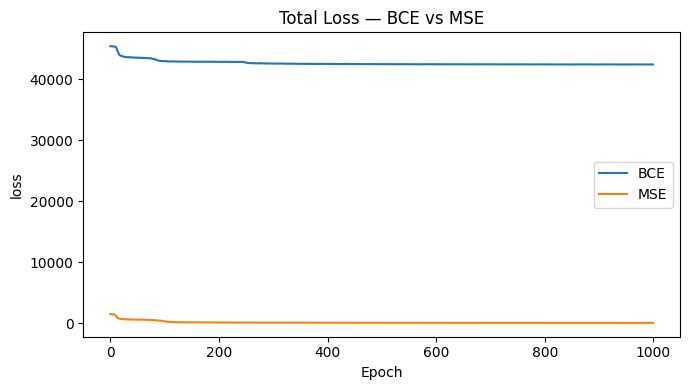

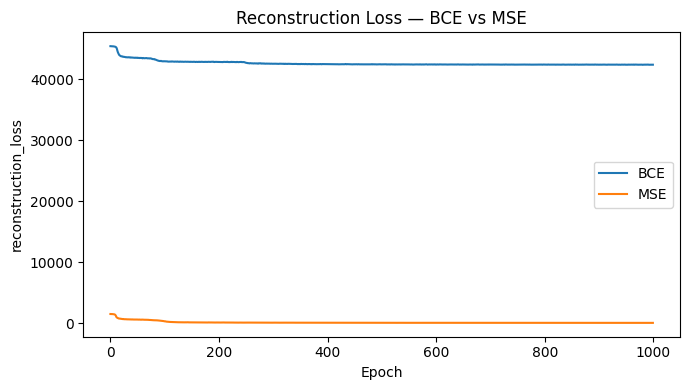

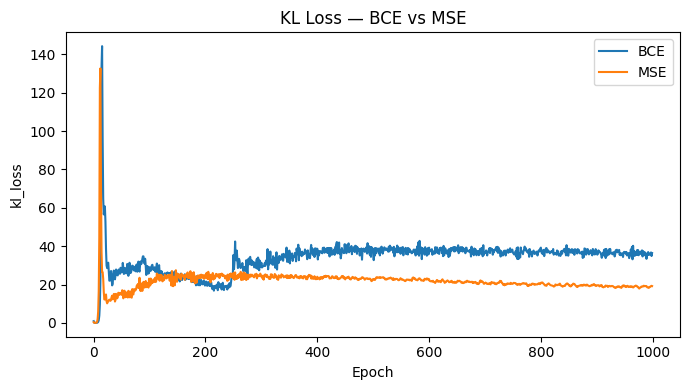

In [9]:
# Cell 9 — Comparison plots for BCE vs MSE (REPLACED)

def plot_metric(metric_key, title):
    plt.figure(figsize=(7,4))
    for loss_name in RECON_LOSSES:
        h = histories[loss_name]
        if metric_key in h:
            plt.plot(h[metric_key], label=f"{loss_name.upper()}")
    plt.xlabel("Epoch"); plt.ylabel(metric_key)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.savefig(FIG_DIR / f"{metric_key}_compare_{tag('bce-mse')}.png", dpi=160)
    plt.show()

plot_metric("loss", "Total Loss — BCE vs MSE")
plot_metric("reconstruction_loss", "Reconstruction Loss — BCE vs MSE")
plot_metric("kl_loss", "KL Loss — BCE vs MSE")

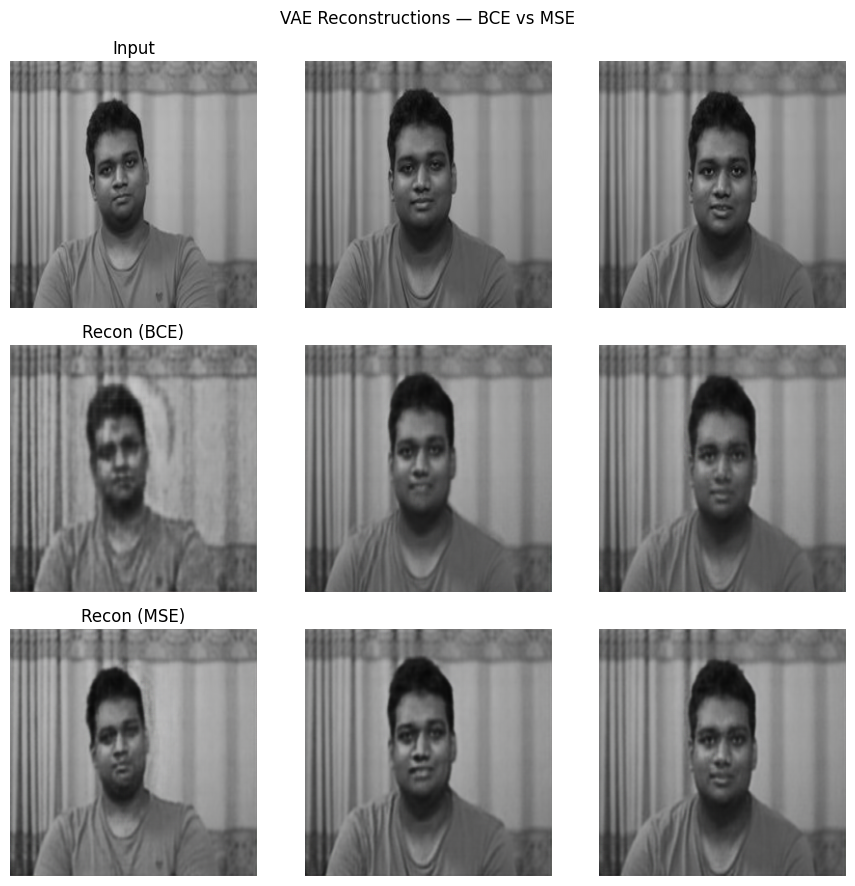

Saved: outputs/figures/recon_grid_compare_bce-mse_latent64_img256.png


In [10]:
# Cell 10 — Side-by-side reconstructions for BCE & MSE (UPDATED)

def recon_grid_side_by_side(models_dict, dataset, max_images=3):
    batch = next(iter(dataset))[:max_images]
    rows = 1 + len(models_dict)   # 1 row inputs + 1 per loss
    cols = max_images

    plt.figure(figsize=(cols*3.0, rows*3.0))
    # Row 0: originals
    for i in range(cols):
        ax = plt.subplot(rows, cols, i + 1)
        plt.imshow(batch[i].numpy())
        plt.axis("off")
        if i == 0: ax.set_title("Input")

    # Subsequent rows: reconstructions
    row_idx = 1
    for loss_name in RECON_LOSSES:
        vae = models_dict[loss_name]
        _, _, z = vae.encoder(batch, training=False)
        x_hat = vae.decoder(z, training=False)
        for i in range(cols):
            ax = plt.subplot(rows, cols, row_idx*cols + i + 1)
            plt.imshow(x_hat[i].numpy())
            plt.axis("off")
            if i == 0: ax.set_title(f"Recon ({loss_name.upper()})")
        row_idx += 1

    plt.suptitle("VAE Reconstructions — BCE vs MSE")
    plt.tight_layout()
    fname = FIG_DIR / f"recon_grid_compare_{tag('bce-mse')}.png"
    plt.savefig(fname, dpi=160)
    plt.show()
    print("Saved:", fname)

# Call with 3 images
recon_grid_side_by_side(models, ds, max_images=3)

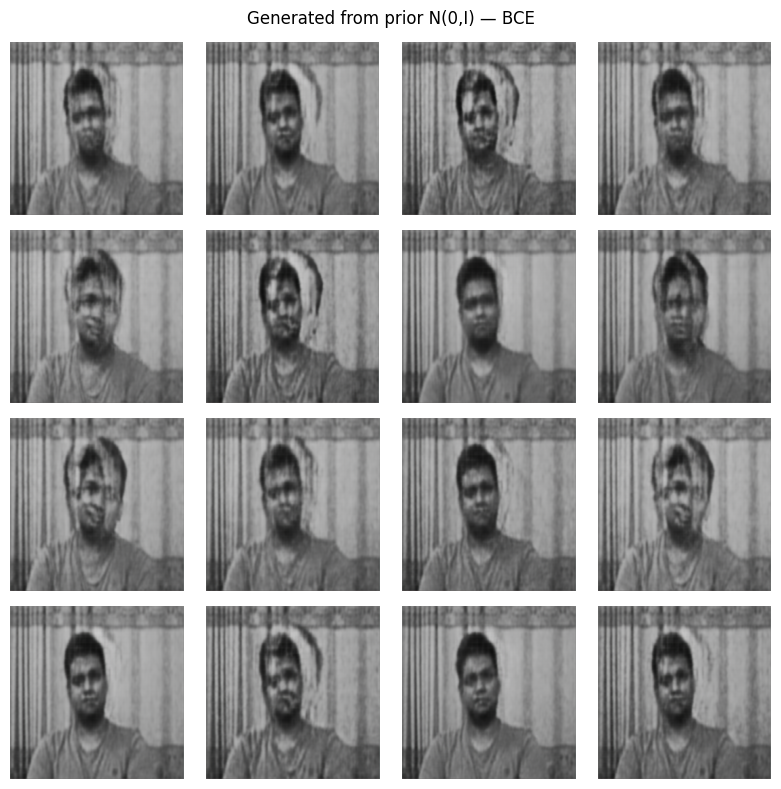

Saved: outputs/generations/samples_prior_bce_latent64_img256.png


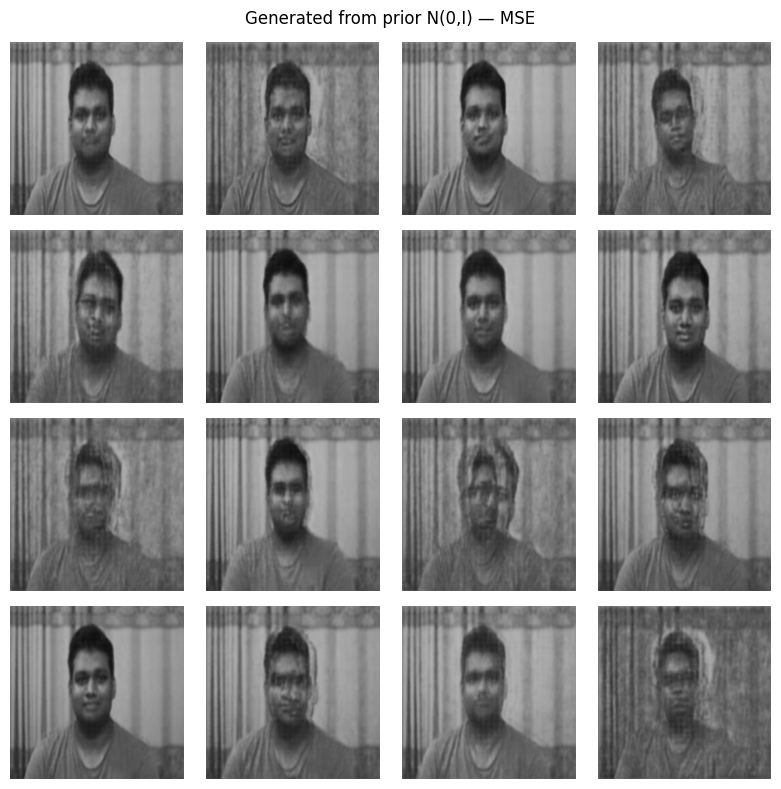

Saved: outputs/generations/samples_prior_mse_latent64_img256.png


In [11]:
# Cell 11 — Generate samples from prior per loss (REPLACED)

def sample_and_save(decoder, n=16, latent_dim=LATENT_DIM, out_path=None, title="Generated samples"):
    z = tf.random.normal(shape=(n, latent_dim))
    imgs = decoder(z, training=False).numpy()
    grid_cols = int(math.sqrt(n))
    grid_rows = int(math.ceil(n / grid_cols))
    plt.figure(figsize=(grid_cols*2, grid_rows*2))
    for i in range(n):
        ax = plt.subplot(grid_rows, grid_cols, i+1)
        plt.imshow(imgs[i])
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    if out_path is not None:
        plt.savefig(out_path, dpi=160)
    plt.show()
    if out_path is not None:
        print("Saved:", out_path)

for loss_name in RECON_LOSSES:
    out_path = GEN_DIR / f"samples_prior_{tag(loss_name)}.png"
    sample_and_save(
        decoders[loss_name], n=16, latent_dim=LATENT_DIM,
        out_path=out_path, title=f"Generated from prior N(0,I) — {loss_name.upper()}"
    )

In [12]:
# Cell 12 — Numeric comparison (PSNR/SSIM) for BCE vs MSE (REPLACED)

def batch_psnr_ssim(x, x_hat):
    psnr = tf.image.psnr(x_hat, x, max_val=1.0)
    ssim = tf.image.ssim(x_hat, x, max_val=1.0)
    return float(tf.reduce_mean(psnr)), float(tf.reduce_mean(ssim))

batch = next(iter(ds))

print("Loss\tPSNR(dB)\tSSIM")
for loss_name in RECON_LOSSES:
    vae = models[loss_name]
    _, _, z = vae.encoder(batch, training=False)
    recon = vae.decoder(z, training=False)
    psnr_mean, ssim_mean = batch_psnr_ssim(batch, recon)
    print(f"{loss_name.upper()}\t{psnr_mean:.2f}\t\t{ssim_mean:.3f}")

Loss	PSNR(dB)	SSIM


2025-09-20 18:54:33.272087: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.58GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


BCE	31.71		0.923
MSE	34.54		0.953
